# Homework 4 Karapet Ghazanjyan

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

In [4]:
conn = sqlite3.connect("/content/drive/MyDrive/Colab Notebooks/spotify.sqlite")
cur = conn.cursor()

In [5]:
query = "SELECT name FROM sqlite_master WHERE type='table'"
cur.execute(query)
pd.read_sql(query, conn)

,name
0,albums
1,artists
2,audio_features
3,genres
4,r_albums_artists
5,r_albums_tracks
6,r_artist_genre
7,r_track_artist
8,tracks


In [5]:
conn.text_factory = lambda x: str(x, 'latin1')

<ipython-input-8-73ef0c6bddb1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-8-73ef0c6bddb1>:35: UserWarning: Glyph 154 (\x9a) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 154 (\x9a) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


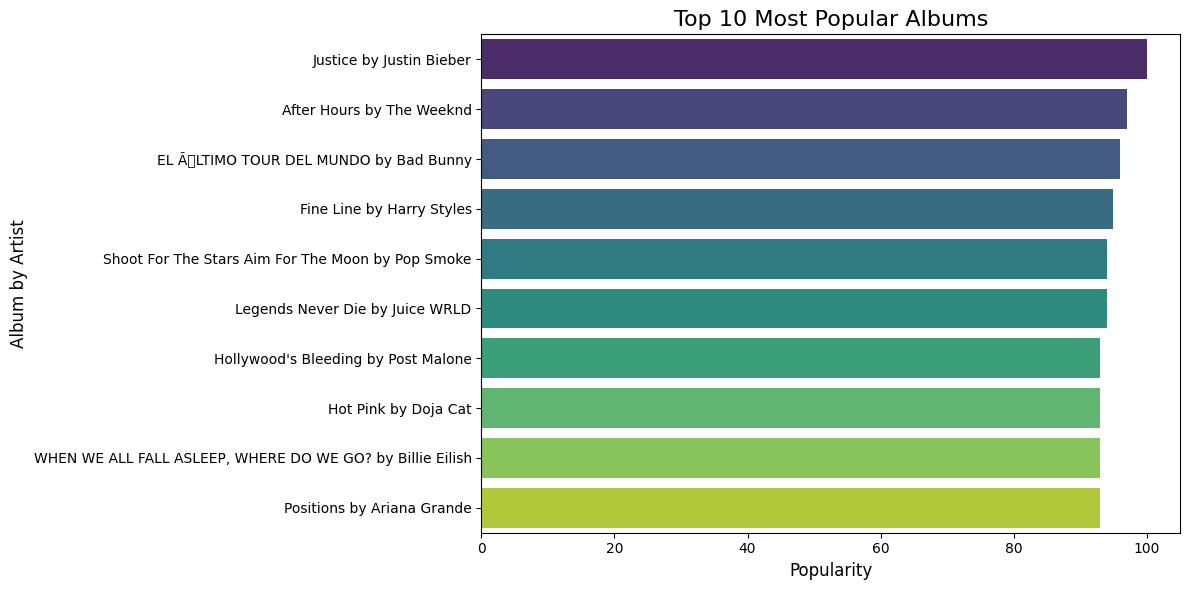

In [8]:
#Top 10 Albums with their artist

data = pd.read_sql_query('''
SELECT
    albums.name as album_name,
    artists.name as artist_name,
    albums.popularity as albums_popularity
FROM
    albums
JOIN
    r_albums_artists ON albums.id = r_albums_artists.album_id
JOIN
    artists ON r_albums_artists.artist_id = artists.id
ORDER BY
    albums.popularity DESC
LIMIT 10;
''', conn)

data['label'] = data['album_name'] + ' by ' + data['artist_name']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=data,
    x='albums_popularity',
    y='label',
    palette='viridis'
)

plt.title('Top 10 Most Popular Albums', fontsize=16)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Album by Artist', fontsize=12)
plt.tight_layout()
plt.show()


Just to check on the top 10 albums. Plotting by descendin order the popularity of the albums with respectful artist names

<ipython-input-10-407efc8bcd5e>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


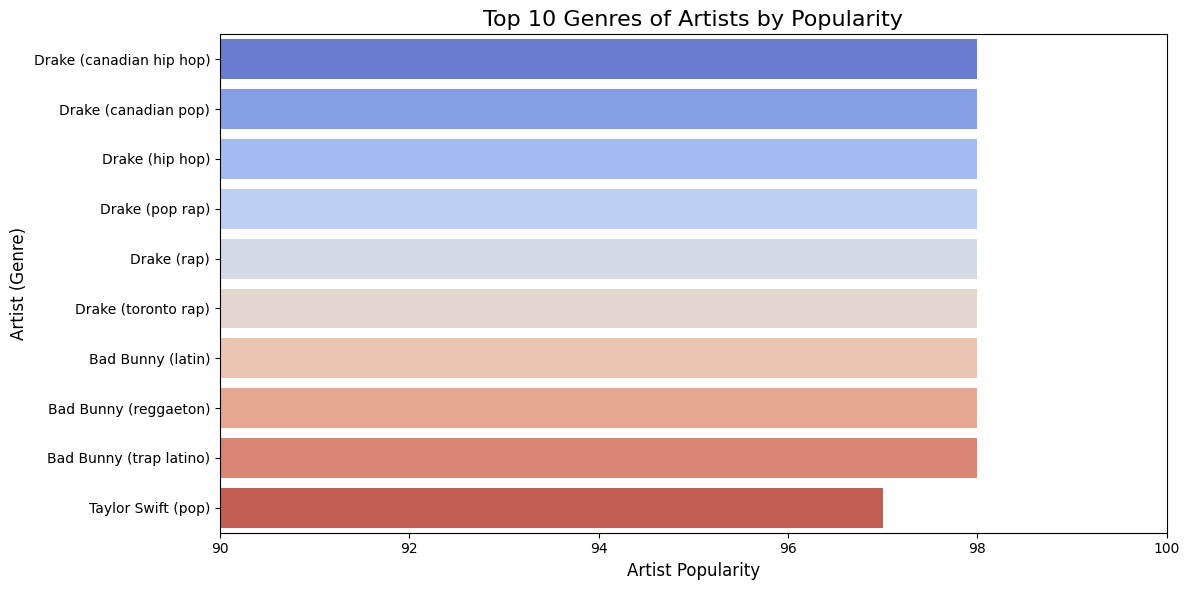

In [10]:
#Top 10 Genres of artists
data = pd.read_sql_query('''
SELECT
    artists.name AS artist_name,
    genres.id AS genre_name,
    artists.popularity as artists_popularity
FROM
    artists
JOIN
    r_artist_genre ON artists.id = r_artist_genre.artist_id
JOIN
    genres ON r_artist_genre.genre_id = genres.id
WHERE
    artists.popularity > 80
ORDER BY
    artists.popularity DESC
LIMIT 10;
''', conn)

data['label'] = data['artist_name'] + ' (' + data['genre_name'] + ')'

plt.figure(figsize=(12, 6))
sns.barplot(
    data=data,
    x='artists_popularity',
    y='label',
    palette='coolwarm'
)

# Adjust the x-axis as the values are between 90-100 and are not visible to me.
plt.xlim(90, 100)

plt.title('Top 10 Genres of Artists by Popularity', fontsize=16)
plt.xlabel('Artist Popularity', fontsize=12)
plt.ylabel('Artist (Genre)', fontsize=12)
plt.tight_layout()
plt.show()

This shows top 10 genres of different artist by popularity. Here we see that our data is dublicated and for example Drake has the top 6 places, and first two are canadian hip hop and canadian pop, or the 3rd row is hip hop, which I assume are same, and as the app has big variety of tags the data was just downloaded and merged and was not filtered.

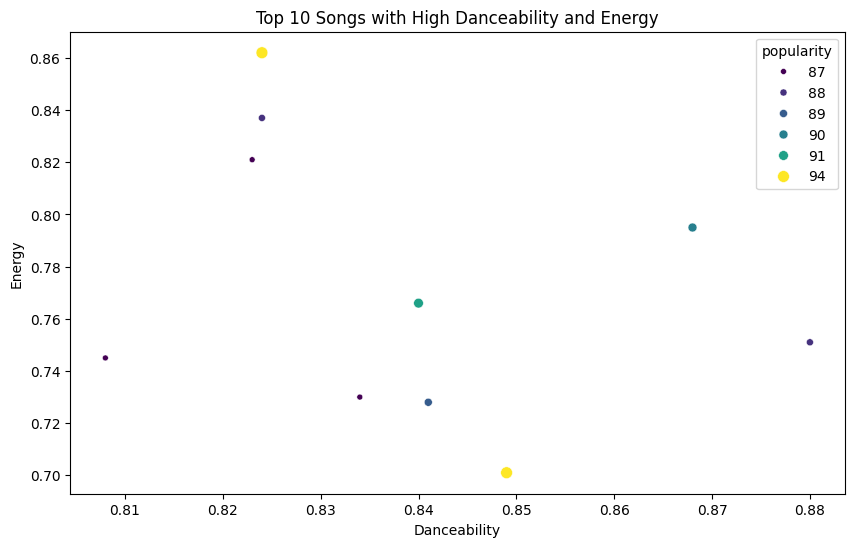

In [11]:
#Top 10 Songs based on popularity with high danceability and energy
df_top_dance_energy = pd.read_sql_query('''
SELECT
    tracks.name AS track_name,
    audio_features.danceability,
    audio_features.energy,
    tracks.popularity
FROM
    audio_features
JOIN
    tracks ON audio_features.id = tracks.audio_feature_id
WHERE
    audio_features.danceability > 0.8 AND audio_features.energy > 0.7
ORDER BY
    tracks.popularity DESC
LIMIT 10;
''', conn)

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top_dance_energy,
    x='danceability',
    y='energy',
    size='popularity',
    hue='popularity',
    palette='viridis',
    legend=True
)
plt.title('Top 10 Songs with High Danceability and Energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.show()

While we checked on the albums and genres, now we look on the top 10 songs with high danceability and energy and a high popularity. As dance club manager will fill hard to read this data, I will sugest to concentrate on yellow and green dots, and the ones who are situated near upper, upper-right, and right corners. This songs will have most danceability, energy and most popularity.

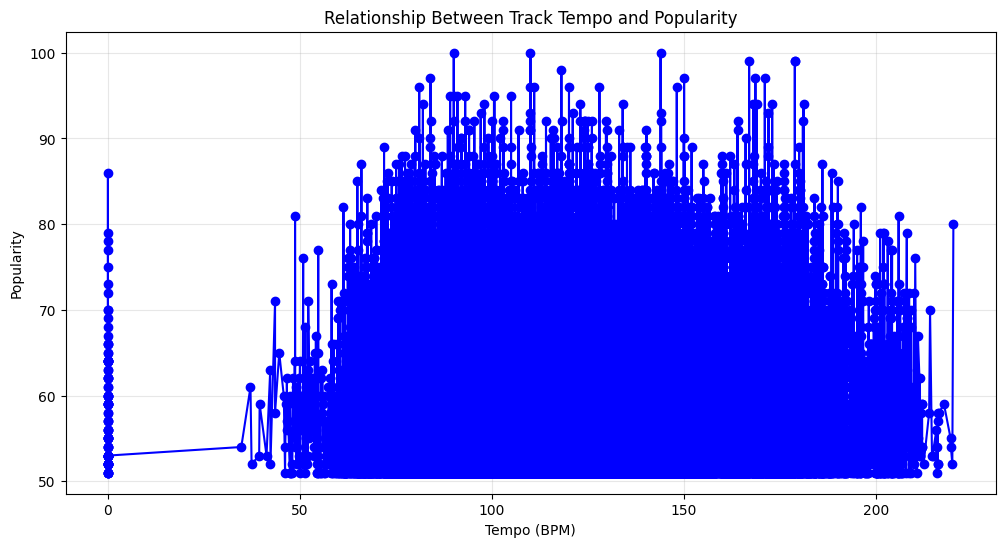

In [12]:
#Relationship between track tempo and popularity
df_tempo_popularity = pd.read_sql_query('''
SELECT
    tracks.name AS track_name,
    audio_features.tempo,
    tracks.popularity
FROM
    audio_features
JOIN
    tracks ON audio_features.id = tracks.audio_feature_id
WHERE
    tracks.popularity > 50
ORDER BY
    audio_features.tempo DESC;
''', conn)

# Plot with Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df_tempo_popularity['tempo'], df_tempo_popularity['popularity'], marker='o', color='b')
plt.title('Relationship Between Track Tempo and Popularity')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Popularity')
plt.grid(alpha=0.3)
plt.show()

Just wanted to check if tempo can be correlated with popularity, as this can be a key role for the further examinations. We see here that songs with highest popularity are situated when tempo is 75 - 175. Here popularity reaches 100. Moreover, there are outliers when tempo is 0. I have connected the dotes to see how the points are scattered and where to be more attentive. (Painted an area where we should concentrate, I was expecting more trends.)

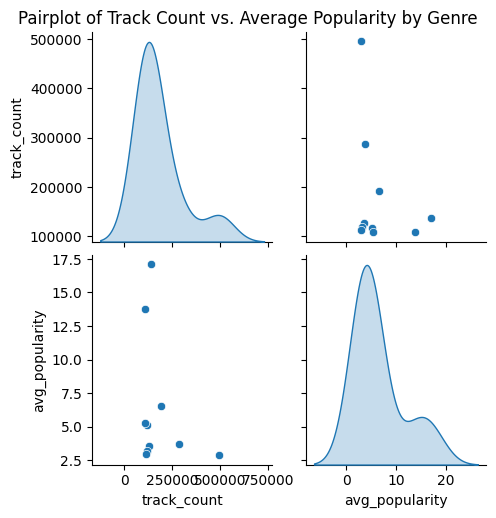

In [13]:
#The most frequent genres and their average popularity.
df_genres_popularity = pd.read_sql_query('''
SELECT
    genres.id AS genre,
    COUNT(*) AS track_count,
    AVG(tracks.popularity) AS avg_popularity
FROM
    genres
JOIN
    r_artist_genre ON genres.id = r_artist_genre.genre_id
JOIN
    r_track_artist ON r_artist_genre.artist_id = r_track_artist.artist_id
JOIN
    tracks ON r_track_artist.track_id = tracks.id
GROUP BY
    genres.id
ORDER BY
    track_count DESC
LIMIT 10;
''', conn)

# Pairplot visualization
sns.pairplot(
    df_genres_popularity,
    vars=["track_count", "avg_popularity"],
    diag_kind="kde",  # Kernel Density Estimate on the diagonal
    kind="scatter",  # Scatter plots between variables
)

plt.suptitle("Pairplot of Track Count vs. Average Popularity by Genre", y=1.02)
plt.show()

Here we see each genre, its track counts and average popularity. This is a reason of many songs having 0 popularity, that means that either they are never rated or maybe in early versions of spotify they did not have that feature (maybe they were outsourcing, like some movie websites from IMDB or etc.) And after getting the data they changed the NAN values to 0. That's why either 0's should be removed with respective rows which will damage the overall output, either some ML model should be applied to fit missing or damaged datas. Just used a pairplot to show that we can combine several graphs, Also we can show up them as a distribution , as points can visibly mislead while the way distributions shows can behave more accurately for end users.

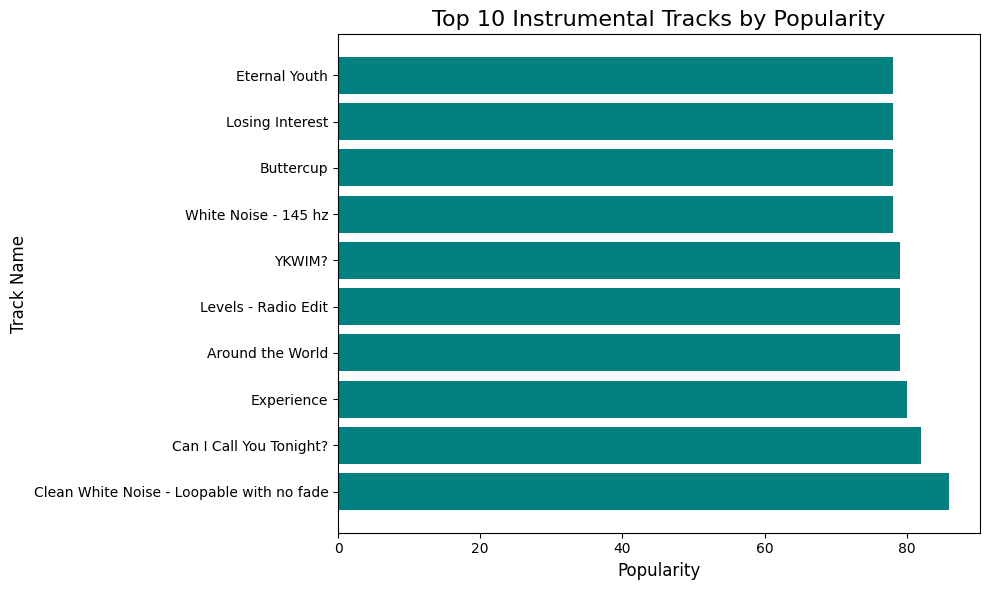

In [15]:
#Identify instrumental tracks with a high popularity score.
instrumental_tracks_df = pd.read_sql_query('''
SELECT
    tracks.name AS track_name,
    audio_features.instrumentalness,
    tracks.popularity
FROM
    audio_features
JOIN
    tracks ON audio_features.id = tracks.audio_feature_id
WHERE
    audio_features.instrumentalness > 0.8
ORDER BY
    tracks.popularity DESC
LIMIT 10;
''', conn)

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(instrumental_tracks_df['track_name'], instrumental_tracks_df['popularity'], color='teal')
plt.title('Top 10 Instrumental Tracks by Popularity', fontsize=16)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Track Name', fontsize=12)
plt.tight_layout()
plt.show()

Also we see here that high instrumentalness can lead to higher than average popularity for tracks, which also means its correlation is higher than average. Here are all values for instrumentalnesss more than 0.8

In [8]:
#Identify tracks with high acousticness scores and their popularity.
df_high_acousticness = pd.read_sql_query('''
SELECT
    tracks.name AS track_name,
    audio_features.acousticness,
    tracks.popularity
FROM
    audio_features
JOIN
    tracks ON audio_features.id = tracks.audio_feature_id
WHERE
    audio_features.acousticness > 0.8
ORDER BY
    tracks.popularity DESC
LIMIT 10;
''', conn)

# Plot with Plotly
fig = px.bar(
    df_high_acousticness,
    x='track_name',
    y='popularity',
    color='acousticness',
    title='Top Tracks with High Acousticness Scores',
    labels={'track_name': 'Track Name', 'popularity': 'Popularity'},
    color_continuous_scale='blues'
)
fig.update_layout(xaxis_title='Track Name', yaxis_title='Popularity', xaxis_tickangle=-45)
fig.show()

The brighter the color the lower is the acousticness. Here we see that some tracks have low acousticness like "Arcacde" but it is popular, and opposite higher acousticness can have a high popularity.

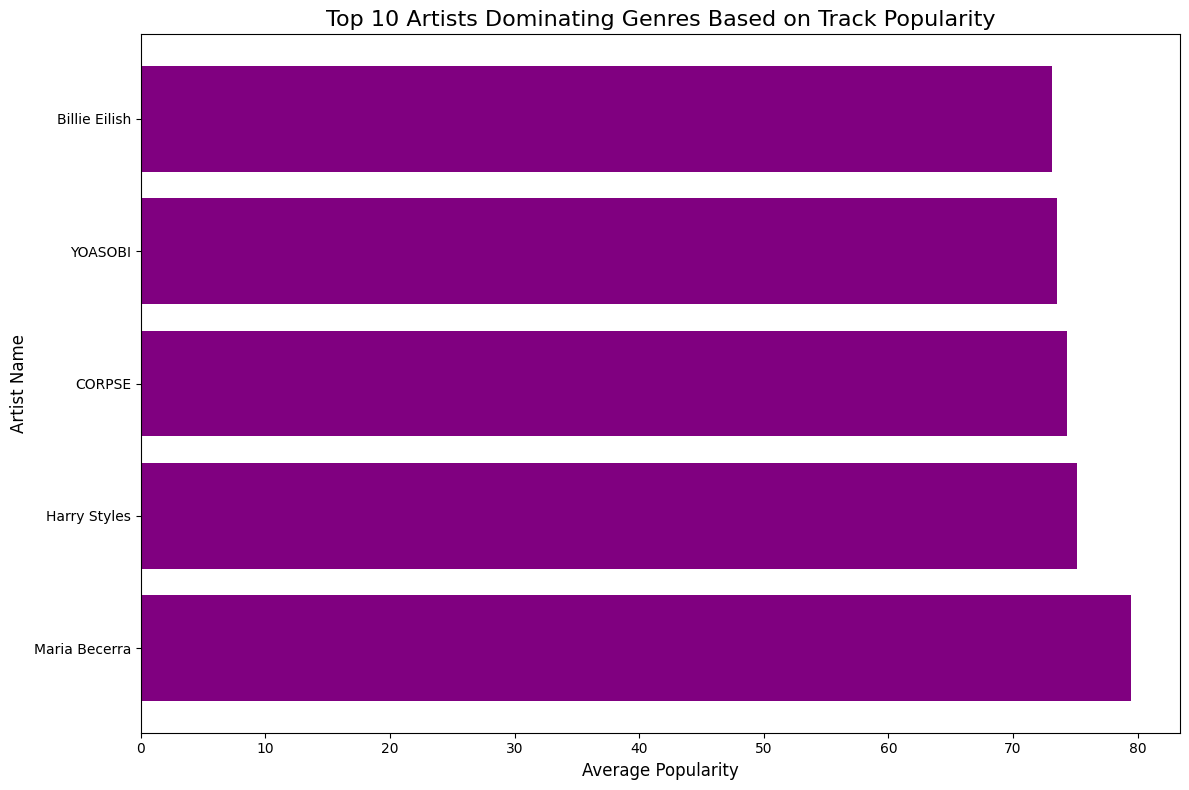

In [9]:
#Identify which artists dominate specific genres in terms of track popularity.
artists_genre_df = pd.read_sql_query('''
SELECT
    genres.id AS genre,
    artists.name AS artist_name,
    AVG(tracks.popularity) AS avg_popularity,
    COUNT(tracks.id) AS track_count
FROM
    genres
JOIN
    r_artist_genre ON genres.id = r_artist_genre.genre_id
JOIN
    artists ON r_artist_genre.artist_id = artists.id
JOIN
    r_track_artist ON artists.id = r_track_artist.artist_id
JOIN
    tracks ON r_track_artist.track_id = tracks.id
GROUP BY
    genre, artist_name
HAVING
    track_count > 5 -- To filter artists with a reasonable number of tracks in the genre
ORDER BY
    avg_popularity DESC, track_count DESC
LIMIT 10;
''', conn)

plt.figure(figsize=(12, 8))
plt.barh(artists_genre_df['artist_name'], artists_genre_df['avg_popularity'], color='purple')
plt.xlabel('Average Popularity', fontsize=12)
plt.ylabel('Artist Name', fontsize=12)
plt.title('Top 5 Artists Dominating Genres Based on Track Popularity', fontsize=16)
plt.tight_layout()
plt.show()

Top 5 artist based on Average popularity.
As data is dublicated, here pops up only 5 of them.


<ipython-input-10-0431c7d246d2>:37: UserWarning:

Glyph 154 (\x9a) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 154 (\x9a) missing from current font.



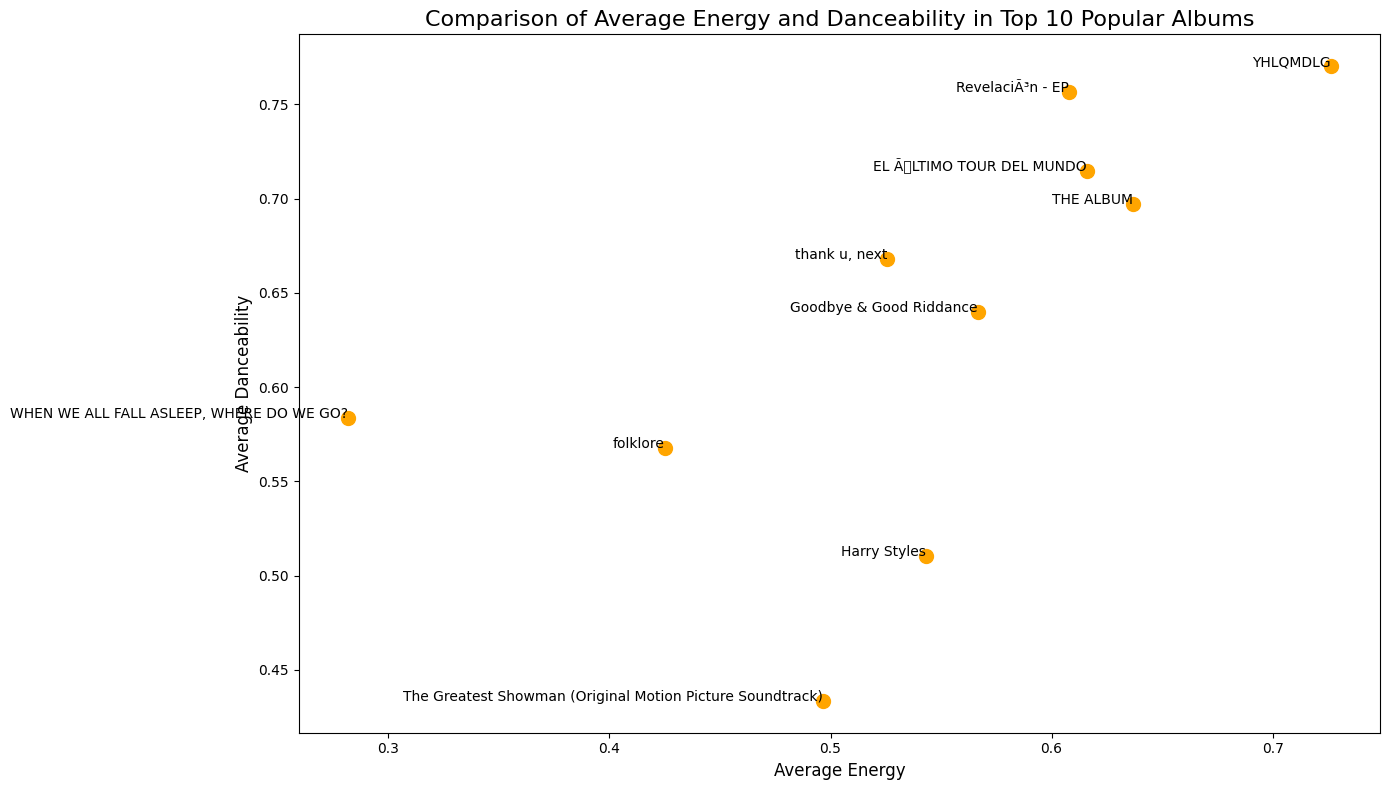

In [10]:
#Compare the average energy and danceability of tracks within the most popular albums.
album_features_df = pd.read_sql_query('''
SELECT
    albums.name AS album_name,
    AVG(audio_features.energy) AS avg_energy,
    AVG(audio_features.danceability) AS avg_danceability,
    AVG(tracks.popularity) AS avg_popularity,
    COUNT(tracks.id) AS track_count
FROM
    albums
JOIN
    r_albums_tracks ON albums.id = r_albums_tracks.album_id
JOIN
    tracks ON r_albums_tracks.track_id = tracks.id
JOIN
    audio_features ON tracks.audio_feature_id = audio_features.id
GROUP BY
    album_name
HAVING
    track_count > 5
ORDER BY
    avg_popularity DESC
LIMIT 10;
''', conn)

plt.figure(figsize=(14, 8))
plt.scatter(album_features_df['avg_energy'], album_features_df['avg_danceability'],
            color='orange', s=100)

for i, album in enumerate(album_features_df['album_name']):
    plt.text(album_features_df['avg_energy'].iloc[i], album_features_df['avg_danceability'].iloc[i],
             album, fontsize=10, ha='right')

plt.title('Comparison of Average Energy and Danceability in Top 10 Popular Albums', fontsize=16)
plt.xlabel('Average Energy', fontsize=12)
plt.ylabel('Average Danceability', fontsize=12)
plt.tight_layout()
plt.show()

Here we are checking averages for the albums, as there are many tracks in each of them, and by this we can conclude that average energy is from 0.5 to 0.6, and average danceability is more than 0.5 and higher, the album can be very popular, even having less than 10 tracks in it.

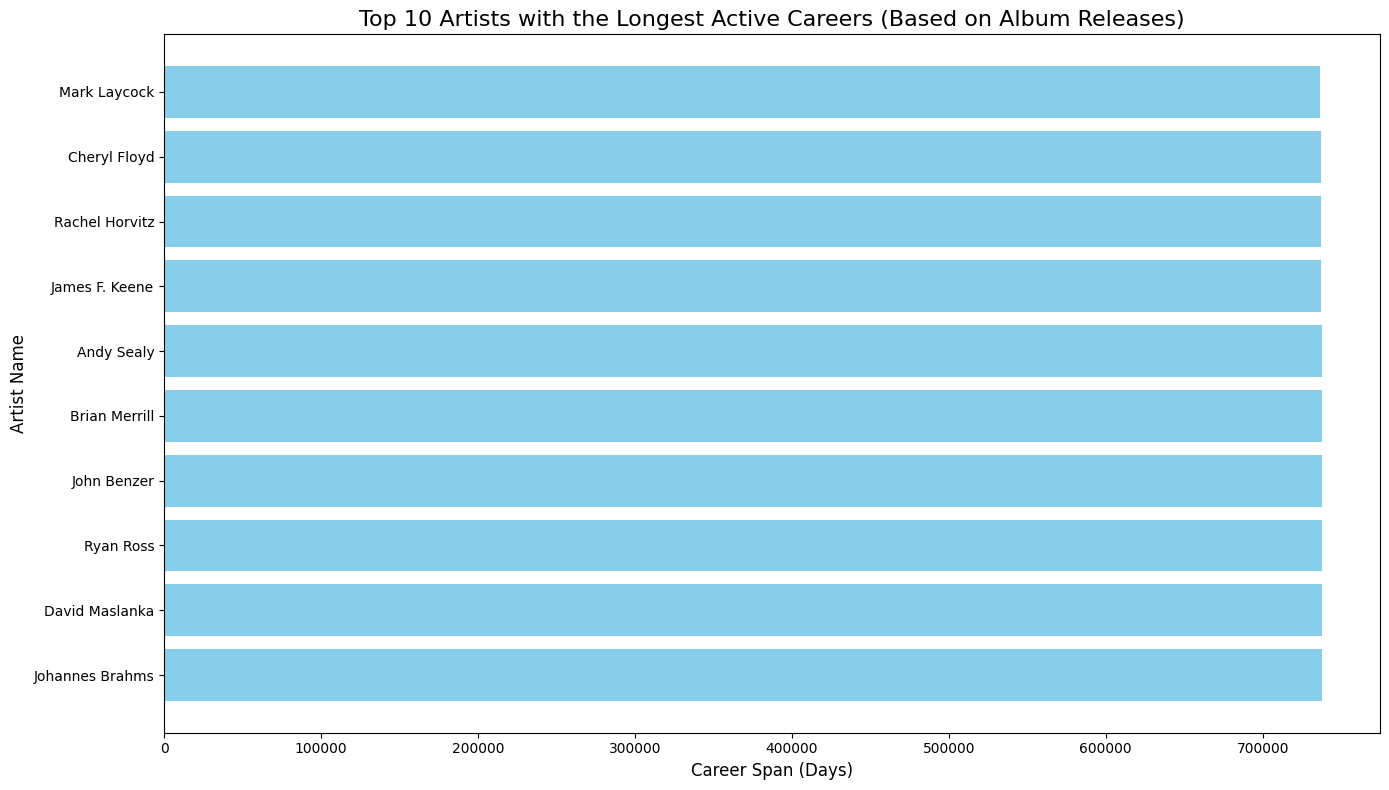

In [11]:
#Identify artists with the longest active careers (based on track release dates).
career_span_df = pd.read_sql_query('''
SELECT
    artists.name AS artist_name,
    MIN(DATE(albums.release_date / 1000, 'unixepoch')) AS first_release,
    MAX(DATE(albums.release_date / 1000, 'unixepoch')) AS last_release,
    (julianday(MAX(DATE(albums.release_date / 1000, 'unixepoch'))) -
     julianday(MIN(DATE(albums.release_date / 1000, 'unixepoch')))) AS career_span_days
FROM
    artists
JOIN
    r_albums_artists ON artists.id = r_albums_artists.artist_id
JOIN
    albums ON r_albums_artists.album_id = albums.id
GROUP BY
    artist_name
ORDER BY
    career_span_days DESC
LIMIT 10;
''', conn)

# Bar plot: Artist career span (in days)
plt.figure(figsize=(14, 8))
plt.barh(career_span_df['artist_name'], career_span_df['career_span_days'], color='skyblue')
plt.title('Top 10 Artists with the Longest Active Careers (Based on Album Releases)', fontsize=16)
plt.xlabel('Career Span (Days)', fontsize=12)
plt.ylabel('Artist Name', fontsize=12)
plt.tight_layout()
plt.show()

It is interesting that first realease is same for most of them, means it was set by default by spotify database team, while for last release the dates are correct, so career span days cannot be calculated correctly. For example "Johannes Brahms' sympony 1 was in 1876 November 4, which is not correct based on this data. Also here by the span days we can understand that something is wrong in the data and it need to be cleaned or adjusted.

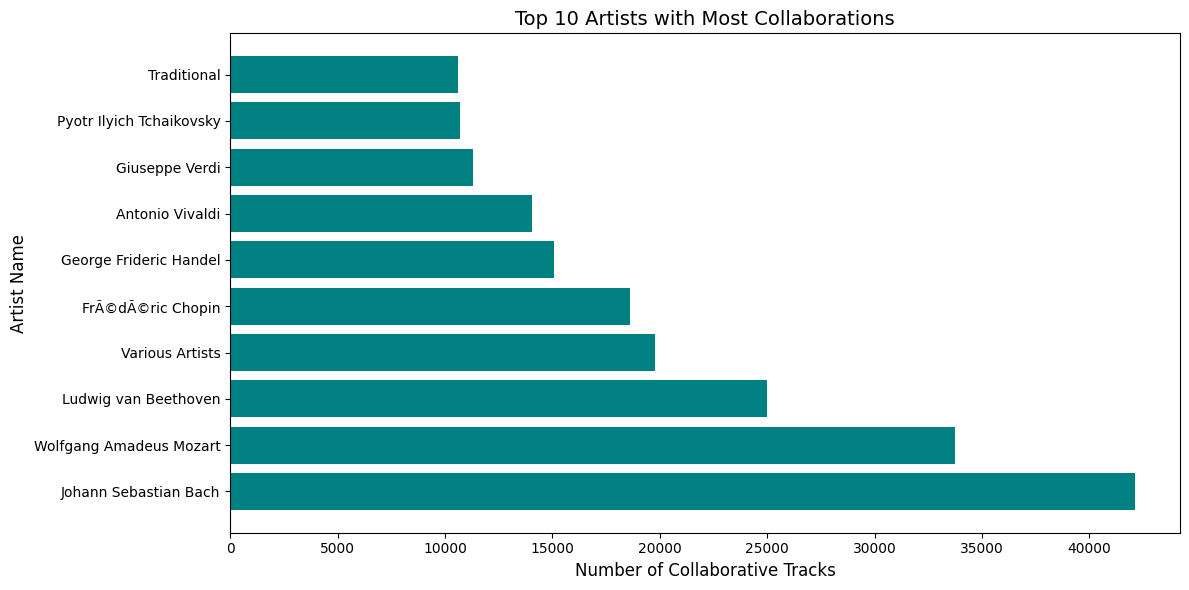

In [13]:
#Find artists who appear most frequently in collaborations.
collaborative_artists_df = pd.read_sql_query('''
SELECT
    artists.name AS artist_name,
    COUNT(DISTINCT tracks.id) AS collaborative_tracks
FROM
    artists
JOIN
    r_track_artist ON artists.id = r_track_artist.artist_id
JOIN
    tracks ON r_track_artist.track_id = tracks.id
GROUP BY
    artist_name
HAVING
    COUNT(DISTINCT tracks.id) > 5
ORDER BY
    collaborative_tracks DESC
LIMIT 10;
''', conn)

# Bar plot for the top 10 artists by collaborative track count
plt.figure(figsize=(12, 6))
plt.barh(collaborative_artists_df['artist_name'], collaborative_artists_df['collaborative_tracks'], color='teal')
plt.xlabel('Number of Collaborative Tracks', fontsize=12)
plt.ylabel('Artist Name', fontsize=12)
plt.title('Top 10 Artists with Most Collaborations', fontsize=14)
plt.tight_layout()
plt.show()

Top 10 artists who are collobarative and have most colloborative trakcs. Can be used in the future for the marketing department. Just not sure if most of them are still alive.

Thanks for this wonderfull semester dear Profesor and TA.

